In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
np.random.seed(1)

In [3]:
df = pd.read_pickle('доходности.pkl')
df.head()

,portfolio_returns_equal,portfolio_returns_conservative,portfolio_returns_aggressive
Date,,,
2008-04-07,-0.017804,-0.004229,-0.028591
2008-04-14,0.071454,0.028481,0.087499
2008-04-21,0.000156,0.000138,-0.001943
2008-04-28,-0.000324,0.004977,-0.022814
2008-05-05,-0.031149,-0.032854,-0.033752


## Value at Risk (VaR)
Это оценка величины доходности, которую не превысят ожидаемые в течение данного периода времени потери с заданной вероятностью.


In [4]:
alpha = 0.05 # Уровень доверия

In [5]:
def value_at_risk(returns, confidence_level):
    """
    Он рассчитывает стоимость под риском (VaR) некоторого временного ряда. Он представляет собой
    максимальный убыток при заданном уровне доверия.

    Parameters
    ----------
    returns : pandas.DataFrame
        Доходности временного ряда.

    confidence_level : int
        Уровень доверия. 5% по умолчанию.

    Returns
    -------
    var : pandas.Series
        Value at Risk для временного ряда.

    """

    # VaR
    return returns.quantile(confidence_level, interpolation='higher')

In [6]:
print(
    'Значения коэффициента Value at Risk (VaR): ', '\n',
    'Портфель с равными весами:', value_at_risk(df.portfolio_returns_equal, alpha), '\n',
    'Консервативный портфель:', value_at_risk(df.portfolio_returns_conservative, alpha), '\n',
    'Агрессивный портфель:', value_at_risk(df.portfolio_returns_aggressive, alpha)
)

Значения коэффициента Value at Risk (VaR):  
 Портфель с равными весами: -0.03266633922362194 
 Консервативный портфель: -0.02810773729444632 
 Агрессивный портфель: -0.03737261524441704


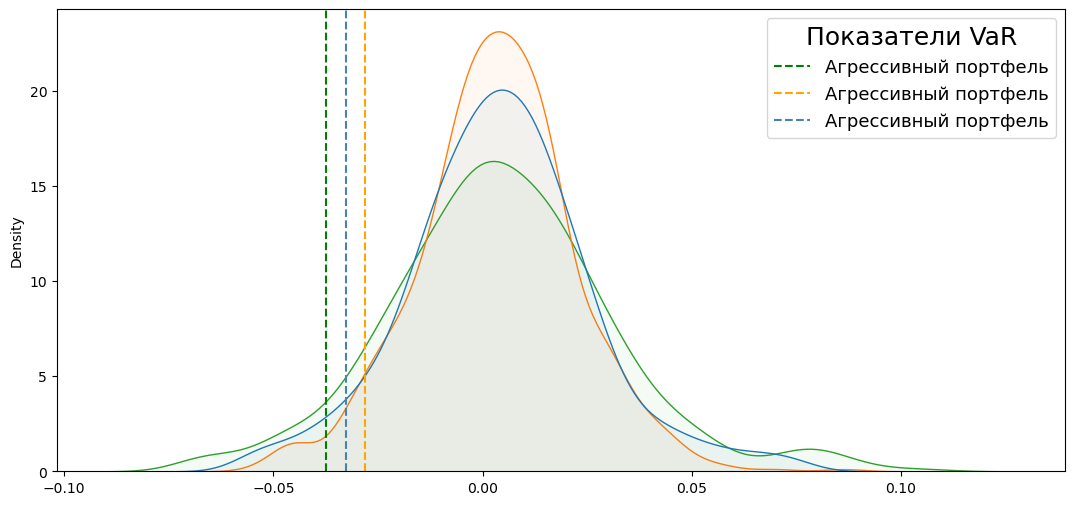

In [7]:
fig, ax = plt.subplots(figsize=(13, 6))

sns.kdeplot(data = df, ax=ax, common_norm=False, fill=True, alpha=0.05)

ax.axvline(value_at_risk(df.portfolio_returns_aggressive, alpha), color='green', linestyle='--', label='Агрессивный портфель')

ax.axvline(value_at_risk(df.portfolio_returns_conservative, alpha), color='orange', linestyle='--', label='Агрессивный портфель')

ax.axvline(value_at_risk(df.portfolio_returns_equal, alpha), color='steelblue', linestyle='--', label='Агрессивный портфель')

ax.legend(fontsize=13, title='Показатели VaR', title_fontsize=18)
# ax.set_xlim((-0.05, 0.05))

С вероятностью 5%, за 1 день величина потерь не превысит полученные значения (по модулю).

## Expected Shortfall (ES) или Conditional Value at Risk(CVaR)

Средняя величина потерь, если коэффициент VaR превышен (в плохие времена)

In [8]:
def expected_shortfall(returns, confidence_level):
    """
    Он рассчитывает Expected Shortfall (ES) некоторого временного ряда. Он представляет
    средние потери в соответствии с Value at Risk.

    Parameters
    ----------
    returns : pandas.DataFrame
        Доходности временного ряда.

    confidence_level : int
        Уровень доверия. 5% по умолчанию.

    Returns
    -------
    es : pandas.Series
        Expected Shortfall для временного ряда.

    """

    # VaR
    var = value_at_risk(returns, confidence_level)

    # ES
    return returns[returns.lt(var)].mean()

In [9]:
print(
    'Значения коэффициента Expected Shortfall (ES): ', '\n',
    'Портфель с равными весами:', expected_shortfall(df.portfolio_returns_equal, alpha), '\n',
    'Консервативный портфель:', expected_shortfall(df.portfolio_returns_conservative, alpha), '\n',
    'Агрессивный портфель:', expected_shortfall(df.portfolio_returns_aggressive, alpha)
)

Значения коэффициента Expected Shortfall (ES):  
 Портфель с равными весами: -0.0428906514769099 
 Консервативный портфель: -0.03711491068863221 
 Агрессивный портфель: -0.05163624021756198


Text(0, 0.5, '')

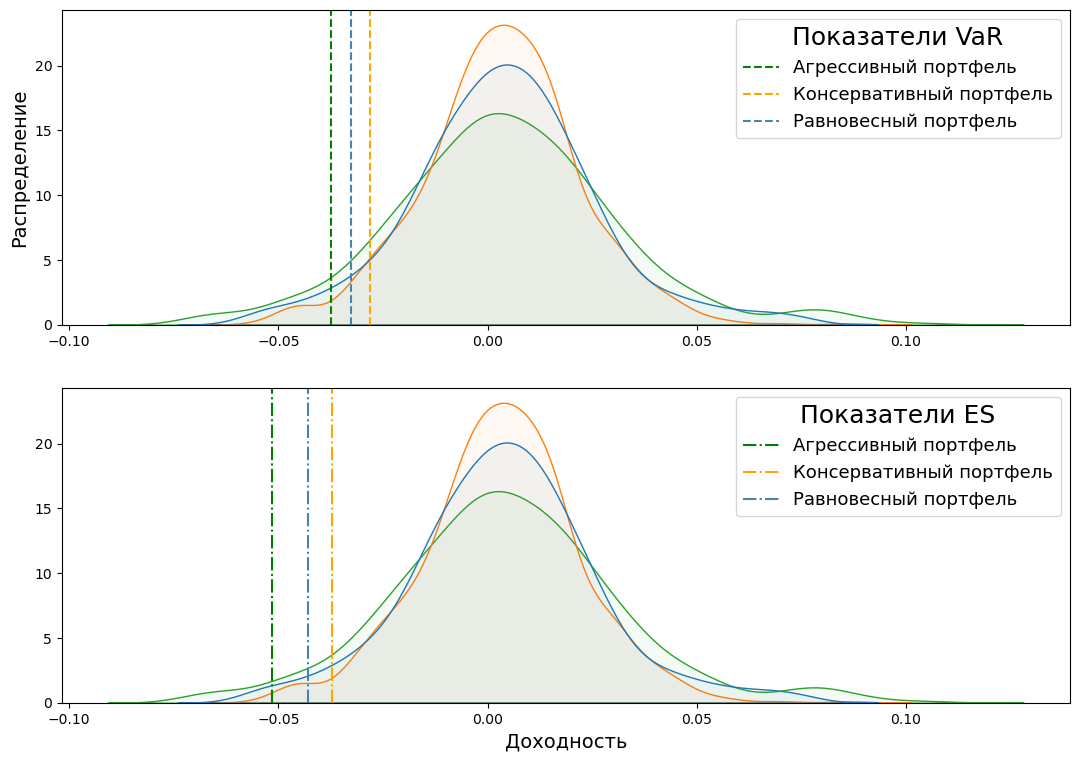

In [10]:
fig, ax = plt.subplots(2, figsize=(13, 9))


sns.kdeplot(data = df, ax=ax[0], common_norm=False, fill=True, alpha=0.05)

ax[0].axvline(value_at_risk(df.portfolio_returns_aggressive, alpha), color='green', linestyle='--', label='Агрессивный портфель')

ax[0].axvline(value_at_risk(df.portfolio_returns_conservative, alpha), color='orange', linestyle='--', label='Консервативный портфель')

ax[0].axvline(value_at_risk(df.portfolio_returns_equal, alpha), color='steelblue', linestyle='--', label='Равновесный портфель')

ax[0].legend(fontsize=13, title='Показатели VaR', title_fontsize=18)
# ax.set_xlim((-0.05, 0.05))


sns.kdeplot(data=df, ax=ax[1], common_norm=False, fill=True, alpha=0.05)

ax[1].axvline(expected_shortfall(df.portfolio_returns_aggressive, alpha), color='green', linestyle='-.', label='Агрессивный портфель')

ax[1].axvline(expected_shortfall(df.portfolio_returns_conservative, alpha), color='orange', linestyle='-.', label='Консервативный портфель')


ax[1].axvline(expected_shortfall(df.portfolio_returns_equal, alpha), color='steelblue', linestyle='-.', label='Равновесный портфель')

ax[1].legend(fontsize=13, title='Показатели ES', title_fontsize=18)

ax[1].set_xlabel('Доходность', fontsize=14)
ax[0].set_ylabel('Распределение', fontsize=14)
ax[1].set_ylabel('')

# ax.set_xlim((-0.03, 0.03))

## Симуляция Монте-Карло

In [11]:
def monte_carlo(tickers, weights, T, mc_sims):  # T - количество недель, mc_sims - количество симуляций

    # Ковариационная матрица
    covMatrix = tickers.cov()

    # Средняя доходность
    meanReturns = tickers.mean()

    meanM = np.full(shape=(T, len(weights)), fill_value=meanReturns)
    meanM = meanM.T

    portfolio_sims = np.full(shape=(T, mc_sims), fill_value=0.0)

    for m in range(0, mc_sims):
        Z = np.random.normal(size=(T, len(weights))) # Генерация случайных значений для каждой акции в портфеле на каждую неделю моделирования
        L = np.linalg.cholesky(covMatrix) # Разложение Холецкого ковариационной матрицы для получения нижнетреугольной матрицы
        dailyReturns = meanM + np.inner(L, Z) # Коррелированные дневные доходы по отдельным акциям
        portfolio_sims[:,m] = np.cumprod(np.inner(weights, dailyReturns.T)+1)-1

    return portfolio_sims

In [12]:
tickers = pd.read_pickle('tickers.pkl')

equal_weights = [1/5, 1/5, 1/5, 1/5, 1/5]
conservative_weights = [0.05, 0.1, 0.4, 0.4, 0.05]
aggressive_weights = [0.4, 0.1, 0.05, 0.05, 0.4]

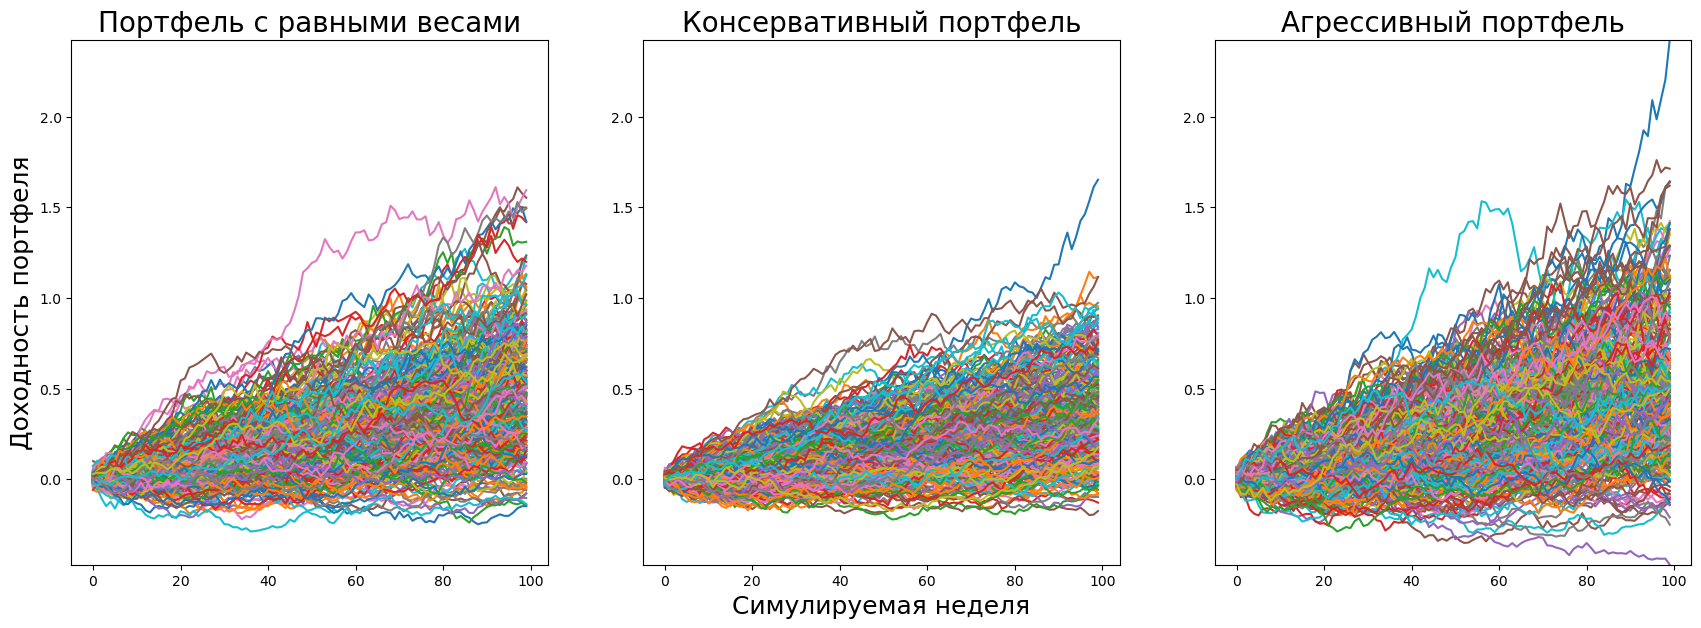

In [13]:
portfolio_sims_equal = monte_carlo(tickers, equal_weights, 100, 300)
portfolio_sims_conservative = monte_carlo(tickers, conservative_weights, 100, 300)
portfolio_sims_aggressive = monte_carlo(tickers, aggressive_weights, 100, 300)

fig, ax = plt.subplots(1, 3, figsize=(18, 7))

ax[0].plot(portfolio_sims_equal)
ax[1].plot(portfolio_sims_conservative)
ax[2].plot(portfolio_sims_aggressive)


ax[1].set_xlabel('Симулируемая неделя', fontsize=18)
ax[0].set_ylabel('Доходность портфеля', fontsize=18)


ax[0].set_title('Портфель с равными весами',  fontsize=20)
ax[1].set_title('Консервативный портфель', fontsize=20)
ax[2].set_title('Агрессивный портфель', fontsize=20)

ymin = min([portfolio_sims_equal.min(), (portfolio_sims_conservative.min()),portfolio_sims_aggressive.min()])
ymax = max([portfolio_sims_equal.max(), (portfolio_sims_conservative.max()),portfolio_sims_aggressive.max()])

ax[0].set_ylim([ymin, ymax])
ax[1].set_ylim([ymin, ymax])
ax[2].set_ylim([ymin, ymax])

# fig.suptitle('Симуляция Монте-Карло', fontsize=30)

fig.subplots_adjust(wspace=0.2, hspace=0.3, left=0.05, right=0.95, bottom=0.1, top=0.9)
fig.subplots_adjust(top=0.85)

In [14]:
# доходности за разные итерации в последний день

portfolio_Results_equal = pd.Series(portfolio_sims_equal[-1,:])
portfolio_Results_conservative = pd.Series(portfolio_sims_conservative[-1,:])
portfolio_Results_aggressive = pd.Series(portfolio_sims_aggressive[-1,:])

In [15]:
print(
    'Значения коэффициента Value at Risk (VaR): ', '\n',
    'Портфель с равными весами:', value_at_risk(portfolio_Results_equal, alpha), '\n',
    'Консервативный портфель:', value_at_risk(portfolio_Results_conservative, alpha), '\n',
    'Агрессивный портфель:', value_at_risk(portfolio_Results_aggressive, alpha), '\n'
)
print(
    'Значения коэффициента Expected Shortfall (ES): ', '\n',
    'Портфель с равными весами:', expected_shortfall(portfolio_Results_equal, alpha), '\n',
    'Консервативный портфель:', expected_shortfall(portfolio_Results_conservative, alpha), '\n',
    'Агрессивный портфель:', expected_shortfall(portfolio_Results_aggressive, alpha)
)

Значения коэффициента Value at Risk (VaR):  
 Портфель с равными весами: -0.006077783706517126 
 Консервативный портфель: -0.004733864002680943 
 Агрессивный портфель: -0.012815528069748505 

Значения коэффициента Expected Shortfall (ES):  
 Портфель с равными весами: -0.07612129682699795 
 Консервативный портфель: -0.06451702037337842 
 Агрессивный портфель: -0.14327849447989233


In [16]:
portfolio_Results_optimal = pd.read_pickle('последняя_симуляция_монте_карло_оптимальный.pkl')
df['portfolio_returns_optimal'] = pd.read_pickle('portfolio_returns_optimal.pkl')

(-0.15, 0.06)

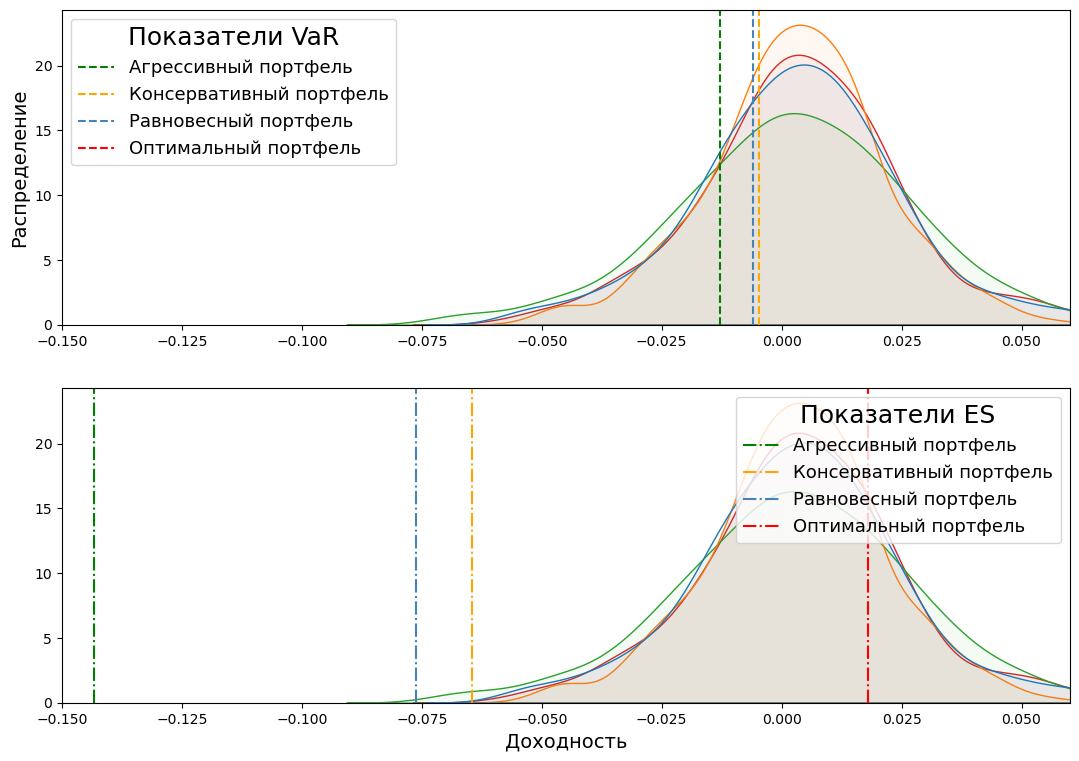

In [17]:
fig, ax = plt.subplots(2, figsize=(13, 9))


sns.kdeplot(data = df, ax=ax[0], common_norm=False, fill=True, alpha=0.05)

ax[0].axvline(value_at_risk(portfolio_Results_aggressive, alpha), color='green', linestyle='--', label='Агрессивный портфель')

ax[0].axvline(value_at_risk(portfolio_Results_conservative, alpha), color='orange', linestyle='--', label='Консервативный портфель')

ax[0].axvline(value_at_risk(portfolio_Results_equal, alpha), color='steelblue', linestyle='--', label='Равновесный портфель')

ax[0].axvline(value_at_risk(portfolio_Results_optimal[0], alpha), color='red', linestyle='--', label='Оптимальный портфель')

ax[0].legend(fontsize=13, title='Показатели VaR', title_fontsize=18)


sns.kdeplot(data=df, ax=ax[1], common_norm=False, fill=True, alpha=0.05)

ax[1].axvline(expected_shortfall(portfolio_Results_aggressive, alpha), color='green', linestyle='-.', label='Агрессивный портфель')

ax[1].axvline(expected_shortfall(portfolio_Results_conservative, alpha), color='orange', linestyle='-.', label='Консервативный портфель')

ax[1].axvline(expected_shortfall(portfolio_Results_equal, alpha), color='steelblue', linestyle='-.', label='Равновесный портфель')

ax[1].axvline(expected_shortfall(portfolio_Results_optimal[0], alpha), color='red', linestyle='-.', label='Оптимальный портфель')

ax[1].legend(fontsize=13, title='Показатели ES', title_fontsize=18)

ax[1].set_xlabel('Доходность', fontsize=14)
ax[0].set_ylabel('Распределение', fontsize=14)
ax[1].set_ylabel('')


ax[0].set_xlim((-0.15, 0.06))
ax[1].set_xlim((-0.15, 0.06))

## Оценка коэффициентов Шарпа и Сортино

In [18]:
def sharpe_ratio(returns, risk_free_rate):
    # расчет ожидаемой доходности портфеля
    expected_portfolio_return = returns.mean()

    # расчет стандартного отклонения доходности портфеля
    portfolio_std_dev = returns.std(ddof=1)

    # расчет коэффициента Шарпа
    return (expected_portfolio_return - risk_free_rate) / portfolio_std_dev

def sortino_ratio(returns, risk_free_rate, target_return=0):
    # расчет стандартного отклонения отрицательной доходности портфеля
    std_downside_returns = np.std(returns[returns < target_return], ddof=1)

    # расчет коэффициента Сортино
    return (returns.mean() - risk_free_rate) / std_downside_returns

In [19]:
risk_free_rate = 0

print(
    '  Значение коэффициентов Шарпа \n',
    'для портфеля с равными долями: ', sharpe_ratio(df.portfolio_returns_equal, risk_free_rate), '\n',
    'для консервативного портфеля: ', sharpe_ratio(df.portfolio_returns_conservative, risk_free_rate), '\n',
    'для агрессивного портфеля: ', sharpe_ratio(df.portfolio_returns_aggressive, risk_free_rate), '\n \n',
    ' Значение коэффициентов Сортино \n',
    'для портфеля с равными долями: ', sortino_ratio(df.portfolio_returns_equal, risk_free_rate), '\n',
    'для консервативного портфеля: ', sortino_ratio(df.portfolio_returns_conservative, risk_free_rate), '\n',
    'для агрессивного портфеля: ', sortino_ratio(df.portfolio_returns_aggressive, risk_free_rate)
)

  Значение коэффициентов Шарпа 
 для портфеля с равными долями:  0.17887568613895702 
 для консервативного портфеля:  0.17410469672930454 
 для агрессивного портфеля:  0.16287402133227263 
 
  Значение коэффициентов Сортино 
 для портфеля с равными долями:  0.29894819850410137 
 для консервативного портфеля:  0.27824219908257425 
 для агрессивного портфеля:  0.2818693820803574
